# Chap03 - 분류 Classification

## 3.1 MNIST

### SetUp

In [1]:
# 공통
import os
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


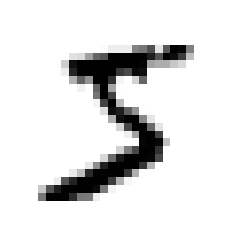

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

실제 정답 레이블을 확인

In [5]:
y[0]

'5'

레이블은 문자열이다. 알고리즘 연산을 위해서 숫자화 필요 

In [6]:
y = y.astype(np.int64)

#### 데이터를 자세히 조하기 전에
: 테스트 세트를 따로 만들고 조사 실시
#### 또한, 데이터셋을 알고리즘 성격에 따라 shuffle 해야한다(단, 시계열 데이터는 제외)
: 수치가 비슷한 샘플들이 연이어 있으면 순서에 민감해짐

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],  y[:60000], y[60000:]

## 3.2 이진 분류기 훈련
숫자가 5인지 아닌지를 분류하는 이진 분류기(binary classifier)를 분류 해본다.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
y_test_5

array([False, False, False, ..., False,  True, False])

## Numpy의 연산
### 1.1 사칙연산
NumPy에서 `*`, `+`, `-` 등 연산자는 ndarray에 있는 magic method로, list와는 달리 각 **element에 해당 계산을 해준다.**

In [10]:
na1 = np.array([1, 2, 3])
na1 * 3

array([3, 6, 9])

### 1.2 비교연산

In [11]:
(na1 == 2)

array([False,  True, False])

#### SGDClassifier
- `SGDClassifier`를 이용해 분류기를 구현
- **확률적 경사 하강법**(Stochastic Gradient Descent)을 이용한 Linear classifiers 이다
- 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있다. 


In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 층정

아래의 예제코드는 위의 `cross_val_score`과 같은 기능을 하는 교차 검증 기능을 `StratifiedKFold`를 이용해 직접 구현한 코드이다. `StratifiedKFold`는 클래스별 비율이 유지되도록 폴드(Fold)를 만들기 위해 계층적 샘플링을 수행한다. 

출력 결과는 위의 결과와 동일한 결과가 출력된다.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


`cross_val_score()`를 사용해서 k-fold 검증을 `SGDClassifier`로 진행해보자.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train,cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

위의 모든 교차 검증 폴드(cross validation fold) 결과는 각 폴드의 예측 비율이 95%이상이다. 
모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들면 다음과 같다

In [17]:
from sklearn.base import BaseEstimator

class Never5Classfier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

정확도: 90% 가 도출 되었지만, 전체 이미지 중 '5'가 차지하는 비율이 10%이므로 예측 자체가 무의미 하다.  
->그러므로, 이러한 데이터넷(**불균형 데이터셋**)accuracy를 classfier의 metric으로 사용은 적절치 못하다

### 3.3.2 오차 행렬
- Classfier의 더 좋은 성능 평가를 위해 사용됨
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 예측값이 필요하기 때문에, `cross_val_predict()`사용
- k-fold 교차 검증을 수행하지만, 평가 점수를 반환 하지 않고, 각 Test Fold에서 얻은 예측 값을 반환

#### 오차 행렬 표
- **TP** : True-Positive, 1이라고 예측했는데, 실제로도 1인 경우 → **정답**
- **TN** : True-Negative, 0이라고 예측했는데, 실제로도 0일 경우 → **정답**
- **FP** : False-Positive, 1이라고 예측했는데, 실제로는 0인 경우
- **FN** : False-Negative, 0이라고 예측했는데, 실제로는 1인 경우   

<img alt="" src="https://t1.daumcdn.net/cfile/tistory/2311A24D55B4FF7B1B" align="center"/>

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

`confusion_matrix()`에서 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [26]:
# 완벽한 분류기 일 경우
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### 정밀도와 재현율
#### Precision (정밀도)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

#### Recall (재현율)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### $\text{F}_{1}$ Score
: 두 가지의 성능지표(precision, Recall)을 하나의 지표로 만들기 위해서 사용. 조화 평균<sub>harmonic mean</sub>라고도 함

$$
\text{F}_{1} = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846